In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics


# read in data and show a preview

path = '/kaggle/input/spotify-dataset-19212020-160k-tracks/data.csv'
df = pd.read_csv(path)
df.head()


,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [2]:
df.info()
# show columns of data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174389 entries, 0 to 174388
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      174389 non-null  float64
 1   artists           174389 non-null  object 
 2   danceability      174389 non-null  float64
 3   duration_ms       174389 non-null  int64  
 4   energy            174389 non-null  float64
 5   explicit          174389 non-null  int64  
 6   id                174389 non-null  object 
 7   instrumentalness  174389 non-null  float64
 8   key               174389 non-null  int64  
 9   liveness          174389 non-null  float64
 10  loudness          174389 non-null  float64
 11  mode              174389 non-null  int64  
 12  name              174389 non-null  object 
 13  popularity        174389 non-null  int64  
 14  release_date      174389 non-null  object 
 15  speechiness       174389 non-null  float64
 16  tempo             17

**Cleaning - Features Selection**

We can remove the "id" and "release_date" columns - id is not useful to us for modelling, and the "year" column already provides us with dates

In [3]:
df = df.drop(labels=['id', 'release_date'], axis=1)
df.shape

(174389, 17)

In [4]:
# check for duplicates and remove
df.duplicated().sum()

3371

In [5]:
df = df[~df.duplicated()==1]
df.shape

(171018, 17)

In [6]:
# check for null values (there are none)
df.isnull().sum().sum()

0

**Exploration!**

In [7]:
numeric_columns = df.columns[df.dtypes != 'object']
string_columns = df.columns[df.dtypes == 'object']
print(f'There are {len(numeric_columns)} numeric columns & {len(string_columns)} string columns')

There are 15 numeric columns & 2 string columns


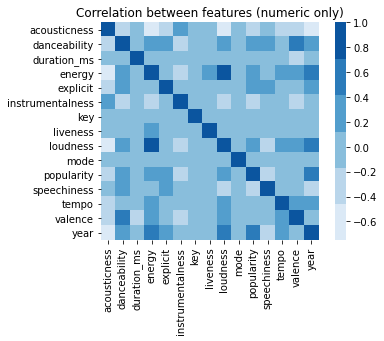

In [8]:
# let's make a heatmap to see feature correlation
numeric_df = pd.DataFrame(data=df, columns=numeric_columns, index=df.index)
corr = numeric_df.corr()
cmap = sns.color_palette("Blues")
sns.heatmap(corr, cmap=cmap, square=True)
plt.title('Correlation between features (numeric only)')
plt.show()

from the heatmap, it seems that year, accosticness, energy, and loudness are the most positively or negatively correlated with popularity. let's check that!

In [9]:
# find which features are most linearly correlated - we will be looking at the absolute value of correlation
series = np.abs(corr['popularity']).sort_values(ascending=False)
for i, row in enumerate(series):
    if 0.25 <= row < 1:
      print(f'{series.index[i]:17} --> {row: .2f} (absolute value)')

year              -->  0.55 (absolute value)
acousticness      -->  0.41 (absolute value)
loudness          -->  0.35 (absolute value)
energy            -->  0.34 (absolute value)
instrumentalness  -->  0.30 (absolute value)


we will use these five features to create our model

**Modeling!**

In [10]:
features = ['year','energy','instrumentalness','acousticness','loudness']
x = df[features].values
y = df['popularity'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [11]:
# create and fit the model
rfr = RandomForestRegressor()
rfr.fit(x_train,y_train)

RandomForestRegressor()

**Evaluate**

In [12]:
# create predictions
rfr_pred = rfr.predict(x_test)
# calculate mean absolute error of model
metrics.mean_absolute_error(y_test,rfr_pred)

8.975937373484244

**Testing**

In [13]:
def songPopularityPrediction(artist, song):
    a=df[df['artists']==artist]
    song = a[a['name']==song]
    x = song[features].values
    pred = rfr.predict(x)
    y=song['popularity'].values
    print (f"predicted value = {pred}")
    print (f"actual value = {y}")

    

In [14]:
songPopularityPrediction("['Phoebe Bridgers']", 'Motion Sickness')


predicted value = [55.57]
actual value = [73]


In [15]:
songPopularityPrediction("['Vampire Weekend']", 'Hannah Hunt')

predicted value = [41.17]
actual value = [54]
